# 九章 KNN 教程

k-Nearest-Neighbors (k-NN) is a supervised machine learning model. 
Supervised learning is when a model learns from data that is already labeled.

Pros:
- 数据量小，效果可以
- 算法简单，适合入门

Cons:
- memory-based learning。要把所有数据都存下来，这些数据就是它的模型，存储量大。 
- 计算量大，每个样本来了都会和已有每一条样本作欧式距离计算，算完后找对好的k个。

In [1]:
import numpy as np # 数组常用库
import pandas as pd # 读入csv常用库
import matplotlib.pyplot as plt # 画图常用库

## Load data
- use .shape to check if all the data have been successfully loaded
- use plt.imshow to see what does data look like

In [2]:
data_dir = './input/'
train_row = 5000 # 如果想取全部数据，设置为最大值 42000
def load_data(data_dir, train_row):
    train = pd.read_csv(data_dir + 'train.csv', sep=',', header=0)
    print(train.shape)
    X_train = train.values[:train_row, 1:]    #attributes特征, .values变成了 2d-ndarray [只读前train_row行:特征]
    y_train = train.values[:train_row,0]  #label  
    
    test_data = pd.read_csv(data_dir + 'test.csv', sep=',', header=0).values   # 无label，只有特征，不用slice
    return X_train, y_train, test_data

origin_X_train, origin_y_train, test_data=load_data(data_dir, train_row)


(42000, 785)


In [3]:
print(origin_X_train.shape, origin_y_train.shape,test_data.shape) 


(5000, 784) (5000,) (28000, 784)


In [4]:
# 看一眼,都是0看不明白
origin_X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

5


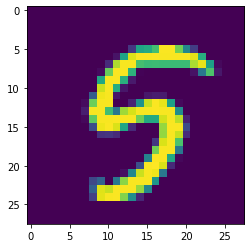

In [5]:
# 所以换成图像看
row=8
print(origin_y_train[row])    #看label
plt.imshow(origin_X_train[row].reshape((28,28)))   

In [35]:
origin_y_train   # 5000个label



array([1, 0, 1, ..., 8, 7, 9])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


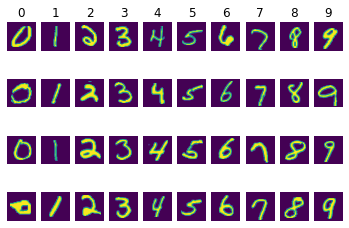

In [46]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
rows = 4

print(classes)
for y, cls in enumerate(classes):
    """
    input: y = 0,1,2,..9   
           origin_y_train: array([1, 0, 1, ..., 8, 7, 9])   #5000个
                                  i 
    output:返回10个tuple列, 每列里都是index值（0-5000）
    (array([   3,   32,   39,   42,   43,   49,   66,   75,   78,   81,   92,
              115,  122,  130,  143,  145,  148,  163,  168,  170,  184,  205,
     ),)
              ...
    """     
    idxs = np.nonzero([i == y for i in origin_y_train]) 
    # print(idxs)
    # print(len(idxs))       #10
    # print(type(idxs))      #tuple
    # print(len(idxs[0]))     # 1 row, N cols
    # print(type(idxs[0]))    # ndarray
    idxs = np.random.choice(idxs[0], rows)  # 每列选4个index， 一共循环10次所以10列
    # print(idxs)
    # [2629 3801 1569 1581]      i=0
    # [3797 1405 3792 2373]      i=1


    for i , idx in enumerate(idxs):
        plt_idx = i * len(classes) + y + 1       #0*10+0+1=1   11,21,31...
        # print(plt_idx)
        plt.subplot(rows, len(classes), plt_idx)   #(4行,10列,1)  (4,10,11) ..
        plt.imshow(origin_X_train[idx].reshape((28, 28))) #  
        plt.axis("off")
        if i == 0:
            plt.title(cls)

plt.show()

    x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
    x
    x[np.nonzero(x)]
    # array([3, 4, 5, 6])

ref: https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html?highlight=nonzero#numpy.nonzero



## Split the data into train and valid data
- training data: 
把原本的训练数据拆分成为20%验证集（8400个），80%训练集（33600个）



In [16]:
from sklearn.model_selection import train_test_split

X_train,X_valid, y_train, y_valid = train_test_split(origin_X_train,
                                                   origin_y_train,
                                                   test_size = 0.2,
                                                   random_state = 0)
# random_state：随机种子； = 0 随机取， = 1 表示不随机
# 这里训练集可以随机分配，不影响训练

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(4000, 784) (1000, 784) (4000,) (1000,)


## Train KNN model
下面进行KNN模型训练 如果是大数据，需要1.5小时跑完

### 分类指标
— sklearn.metrics.accuracy_score(ytest, model.predict(x_test))
获得准确率

— sklearn.metrics.confusion_matrix(ytest, model.predict(x_test))
获得混淆矩阵

— sklearn.metrics.classification_report(ytest, model.predict(x_test))
获得分类结果详细报告


In [17]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
res_k = 0       #存最好的k
k_range = range(1,8)   #label有9类，从1-7里选
scores=[]

"""
每次把最好的结果存在res_k
每次通过枚举的k训练好一个模型
训练好的模型去验证，得到一个分数
最好的分数对应最好的k
"""
for k in k_range:
    print("k = " + str(k) + " train start: ")
    start = time.time()

    """
    建立KNN模型
    """
    knn=KNeighborsClassifier(n_neighbors=k)    #sklearn里直接调. create KNN classifier
    knn.fit(X_train,y_train) # Fit the classifier to the data

    """
    testing the model，对比 y_pred和y_valid 的各项指标
    """
    y_pred=knn.predict(X_valid)   
    accuracy = accuracy_score(y_valid,y_pred) 
    scores.append(accuracy)
    end = time.time()
    print("Complete time: " + str(end-start) + " Secs.")
    print(accuracy)  
    print(classification_report(y_valid,y_pred)) 
    print(confusion_matrix(y_valid,y_pred)) 
    


k = 1 train start: 
Complete time: 10.20741891860962 Secs.
0.919
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       103
           1       0.90      0.98      0.94       100
           2       0.97      0.88      0.92       104
           3       0.89      0.93      0.91       100
           4       0.93      0.93      0.93       107
           5       0.95      0.88      0.92        94
           6       0.93      0.97      0.95        93
           7       0.92      0.94      0.93       116
           8       0.89      0.85      0.87        85
           9       0.85      0.85      0.85        98

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

[[101   0   0   1   0   0   1   0   0   0]
 [  0  98   0   1   0   0   0   0   0   1]
 [  0   1  91   2   2   0   1   2   3   2]
 [  0   0   1  93   0   1   0   1   3   1]
 [  

In [18]:
scores

[0.919, 0.906, 0.92, 0.915, 0.915, 0.914, 0.915]

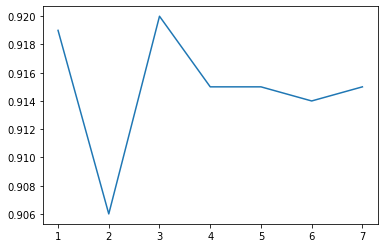

In [19]:
plt.plot(range(1,8),scores)

In [20]:
res_k=3

In [21]:
"""
使用KNN模型测试
"""
knn=KNeighborsClassifier(n_neighbors=res_k)    #sklearn里直接调
knn.fit(X_train,y_train)
#show first 100 model predictions on the test_data
y_pred=knn.predict(test_data[:100])   # replace valid data to test_data
# change this line to y_pred=knn.predict(test_data) for full test

In [22]:
y_pred

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 7, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9,
       8, 7, 8, 2, 6, 1, 6, 8, 8, 3, 8, 2, 1, 2, 1, 0, 4, 1, 7, 0, 0, 0,
       1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 3, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3,
       6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4])

7


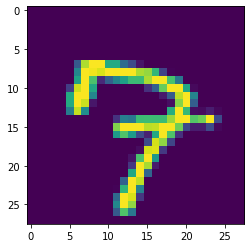

In [23]:
row=5
print(y_pred[row])
plt.imshow(test_data[row].reshape((28,28)))      #把矩阵画成图像
plt.show()              #显示图画

In [24]:
# save submission to csv
pd.DataFrame({"ImageId": list(range(1,len(y_pred)+1)),"Label": y_pred}).to_csv('Digit_Recogniser_Result.csv', index=False,header=True)

## Reference:
- https://www.kaggle.com/c/digit-recognizer
- http://yann.lecun.com/exdb/mnist/
- https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

